# Week 4 Seminar: ML for Alpha — From Features to Signals

> *"Your model has a mean IC of 0.046. That number looks pathetic. It is also, potentially, worth hundreds of millions of dollars. This seminar is about learning to tell the difference."*

The lecture built a cross-sectional alpha pipeline: features at time t, returns at t+1, gradient boosting in between. You saw that an IC of 0.046 is statistically significant, that neural networks and trees converge on the same signal, and that a handful of features dominate regardless of model complexity. Now it is your turn to stress-test those claims.

Four exercises, four questions. Does the signal survive market turbulence, or does it crack when you need it most? Do all seven features actually contribute, or are some of them free-riding on correlated neighbors? Does model complexity buy you anything on a small, efficient universe? And the question that separates research from revenue: after transaction costs, is there anything left?

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import gc
import sys
import time
import warnings
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy import stats
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, RidgeCV

sys.path.insert(0, "code")
from data_setup import (
    CACHE_DIR, FEATURE_COLS, TRAIN_WINDOW, PURGE_GAP,
    load_monthly_panel, load_vix_monthly,
)

sys.path.insert(0, str(Path("code").resolve().parents[1]))
from shared.temporal import walk_forward_splits
from shared.backtesting import (
    long_short_returns, portfolio_turnover, sharpe_ratio, net_returns,
)
from shared.dl_training import fit_nn, predict_nn

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

N_GROUPS = 5  # quintile portfolios for Ex4
device = "cpu"
features = FEATURE_COLS
target = "fwd_return"

# Load all data once for the entire seminar
panel = load_monthly_panel()
dates = panel.index.get_level_values("date").unique().sort_values()

# Load pre-computed GBM outputs from the lecture pipeline
ic_series = pd.read_parquet(CACHE_DIR / "gbm_ic_series.parquet").squeeze()
if isinstance(ic_series, pd.DataFrame):
    ic_series = ic_series.iloc[:, 0]
ic_series.name = "ic"

gbm = pd.read_parquet(CACHE_DIR / "gbm_predictions.parquet")
predictions = gbm["prediction"]
actuals = gbm["actual"]

torch.set_num_threads(1)
vix_monthly = load_vix_monthly()

The setup cell loads every library and dataset that the four exercises need. We also define `N_GROUPS = 5` for the quintile portfolio sort in Exercise 4, and set `device = "cpu"` for the neural network in Exercise 3. All data -- the monthly panel (174 stocks, 7 features, 129 months), pre-computed GBM predictions and IC series, and the VIX regime indicator -- is loaded once and shared across exercises.

In [2]:
# ── Utility functions shared across exercises ──

# Ex2: Walk-forward GBM evaluation for feature knockout
GBM_PARAMS = dict(
    objective="regression", learning_rate=0.05, num_leaves=31,
    n_estimators=500, min_child_samples=20, subsample=0.8,
    colsample_bytree=0.8, verbosity=-1,
)

def _run_walk_forward(panel, features, dates, label):
    """Train GBM walk-forward and return monthly OOS IC (Spearman) series."""
    splits = list(walk_forward_splits(dates, TRAIN_WINDOW, PURGE_GAP))
    ic_values, ic_dates = [], []
    t0 = time.time()
    for i, (train_dates, pred_date) in enumerate(splits):
        if i % 10 == 0:
            print(f"    [{label}] window {i+1}/{len(splits)}  "
                  f"({time.time()-t0:.0f}s elapsed)")
        train_mask = panel.index.get_level_values("date").isin(train_dates)
        pred_mask = panel.index.get_level_values("date") == pred_date
        X_train = panel.loc[train_mask, features]
        y_train = panel.loc[train_mask, "fwd_return"]
        X_pred = panel.loc[pred_mask, features]
        y_pred = panel.loc[pred_mask, "fwd_return"].values
        if len(X_pred) < 10:
            continue
        unique_train = sorted(set(train_dates))
        if len(unique_train) > 12:
            val_dates = unique_train[-12:]
            val_mask = panel.index.get_level_values("date").isin(val_dates)
            fit_mask = train_mask & ~val_mask
            X_fit = panel.loc[fit_mask, features]
            y_fit = panel.loc[fit_mask, "fwd_return"]
            X_val = panel.loc[val_mask, features]
            y_val = panel.loc[val_mask, "fwd_return"]
        else:
            X_fit, y_fit = X_train.copy(), y_train.copy()
            X_val, y_val = None, None
        model = lgb.LGBMRegressor(**GBM_PARAMS)
        fit_kwargs = {}
        if X_val is not None and len(X_val) > 0:
            fit_kwargs["eval_set"] = [(X_val, y_val)]
            fit_kwargs["callbacks"] = [
                lgb.early_stopping(50, verbose=False),
                lgb.log_evaluation(period=-1),
            ]
        model.fit(X_fit, y_fit, **fit_kwargs)
        preds = model.predict(X_pred)
        if np.std(preds) < 1e-12:
            ic_values.append(0.0)
        else:
            ic, _ = spearmanr(preds, y_pred)
            ic_values.append(ic if np.isfinite(ic) else 0.0)
        ic_dates.append(pred_date)
    print(f"    [{label}] done — {len(splits)} windows in {time.time()-t0:.1f}s")
    return pd.Series(ic_values, index=pd.DatetimeIndex(ic_dates), name=label)


# Ex3: Model definitions and walk-forward harness
class SimpleNN(nn.Module):
    def __init__(self, n_features, hidden=32, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, hidden), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

def compute_ic(y_true, y_pred):
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() < 10:
        return np.nan
    return np.corrcoef(y_true[mask], y_pred[mask])[0, 1]

def prediction_quality(y_pred, n_quantiles=5):
    if np.std(y_pred) < 1e-12:
        return 0.0
    q = np.quantile(y_pred, [0.2, 0.8])
    spread = y_pred[y_pred >= q[1]].mean() - y_pred[y_pred <= q[0]].mean()
    return spread / np.std(y_pred)

def walk_forward_model(panel, dates, features, target, model_name, fit_fn,
                       predict_fn, train_window, purge_gap, debug=False):
    splits = list(walk_forward_splits(dates, train_window, purge_gap))
    if debug:
        splits = splits[:3]
    results = []
    t0 = time.time()
    for i, (train_dates, pred_date) in enumerate(splits):
        if i % 10 == 0:
            print(f"  [{model_name}] [{i+1}/{len(splits)}] "
                  f"predicting {pd.Timestamp(pred_date).date()} ({time.time()-t0:.0f}s)")
        train_mask = panel.index.get_level_values("date").isin(train_dates)
        test_mask = panel.index.get_level_values("date") == pred_date
        X_train = panel.loc[train_mask, features].values
        y_train = panel.loc[train_mask, target].values
        X_test = panel.loc[test_mask, features].values
        y_test = panel.loc[test_mask, target].values
        if len(X_test) < 10:
            continue
        valid = np.isfinite(X_train).all(axis=1) & np.isfinite(y_train)
        X_train, y_train = X_train[valid], y_train[valid]
        valid_test = np.isfinite(X_test).all(axis=1) & np.isfinite(y_test)
        X_test, y_test = X_test[valid_test], y_test[valid_test]
        if len(X_train) < 50 or len(X_test) < 10:
            continue
        try:
            fitted = fit_fn(X_train, y_train)
            preds = predict_fn(fitted, X_test)
        except Exception as e:
            print(f"  [{model_name}] Window {i} failed: {e}")
            continue
        ic = compute_ic(y_test, preds)
        sr = prediction_quality(preds)
        results.append({"date": pred_date, "ic": ic, "spread_ratio": sr,
                        "n_stocks": len(y_test)})
    print(f"  [{model_name}] Done: {len(results)} windows in {time.time()-t0:.0f}s")
    return pd.DataFrame(results)

def fit_ols(X, y):
    m = LinearRegression(); m.fit(X, y); return m
def predict_ols(m, X):
    return m.predict(X)
def fit_ridge(X, y):
    m = RidgeCV(alphas=[1e-4, 1e-2, 1.0, 100.0, 1e4]); m.fit(X, y); return m
def predict_ridge(m, X):
    return m.predict(X)
def fit_lgbm_d3(X, y):
    m = lgb.LGBMRegressor(max_depth=3, n_estimators=300, learning_rate=0.05,
        num_leaves=8, subsample=0.8, colsample_bytree=0.8,
        min_child_samples=20, verbose=-1, n_jobs=1)
    n = len(X); split = int(n * 0.8)
    m.fit(X[:split], y[:split], eval_set=[(X[split:], y[split:])],
          callbacks=[lgb.early_stopping(50, verbose=False)])
    return m
def fit_lgbm_d8(X, y):
    m = lgb.LGBMRegressor(max_depth=8, n_estimators=300, learning_rate=0.05,
        num_leaves=63, subsample=0.8, colsample_bytree=0.8,
        min_child_samples=20, verbose=-1, n_jobs=1)
    n = len(X); split = int(n * 0.8)
    m.fit(X[:split], y[:split], eval_set=[(X[split:], y[split:])],
          callbacks=[lgb.early_stopping(50, verbose=False)])
    return m
def predict_lgbm(m, X):
    return m.predict(X)
def make_nn_fit_fn(n_features, device_str):
    def fit_fn(X, y):
        model = SimpleNN(n_features, hidden=32, dropout=0.3)
        n = len(X); split = int(n * 0.8)
        fit_nn(model, X[:split], y[:split], x_val=X[split:], y_val=y[split:],
               epochs=50, lr=1e-3, batch_size=256, patience=10, device=device_str)
        return model
    return fit_fn
def make_nn_predict_fn(device_str):
    def pred_fn(model, X):
        return predict_nn(model, X, device=device_str)
    return pred_fn

The utility cell is long -- it defines helpers that the exercises call repeatedly. The `_run_walk_forward` function encapsulates the full GBM walk-forward loop used in Exercise 2's feature knockout. The `walk_forward_model` function is a generalized version for Exercise 3's complexity ladder, accepting any fit/predict function pair. The model definitions (OLS, Ridge, LightGBM at two depths, neural network) are thin wrappers that Exercise 3 will loop through. Skim the signatures now; the exercises will make the calling patterns clear.

Each exercise below opens with a question, presents a task list, and provides empty cells for you to attempt before revealing the solution. The exercises build on each other conceptually -- regime stability (Ex1), feature redundancy (Ex2), model complexity (Ex3), transaction costs (Ex4) -- but each uses independent code that can run on its own. Work through them in order for the narrative arc, or jump to whichever question interests you most.

---

## Exercise 1: The IC Autopsy

Your gradient boosting model produced a mean IC of 0.046 over 68 out-of-sample months. The lecture presented that as a single number -- statistically significant at the 5% level, sitting at the upper end of the 0.02-0.05 production range. But averages lie. A mean IC of 0.046 could come from 68 months of consistent +0.04 signal, or from 40 months of +0.15 and 28 months of -0.10. The difference matters enormously -- the first is a reliable income stream, the second is a casino with a slight edge.

Here is the question: does your alpha signal behave differently when markets are calm versus when they are panicking? Split the IC series by VIX regime -- high-volatility months versus low-volatility months -- and see what falls out. If the signal reverses in crisis periods, that IC of 0.046 is far less valuable than it looks. Daniel and Moskowitz documented momentum crashes during volatility spikes in a 2016 JFE paper -- our multi-feature GBM signal might show the same pattern, or it might not. The data will tell us.

**Tasks:**
1. Align the VIX series to your IC dates and classify months into high-vol and low-vol regimes using the VIX median as the threshold
2. Compute mean IC, IC standard deviation, and percent-positive separately for each regime
3. Run a Welch two-sample t-test on the high-vol vs. low-vol IC distributions
4. Visualize the IC time series with regime shading

In [3]:
# Your code here — regime classification
# Hint: align VIX to IC dates, compute median split

In [4]:
# Your code here — compute IC statistics per regime

Once you have the per-regime IC statistics, test whether the difference is statistically meaningful. Then visualize the full time series with regime shading to see the pattern your numbers describe.

In [5]:
# Your code here — two-sample t-test

In [6]:
# Your code here — plot IC with regime shading

---

### ▶ Solution

In [7]:
# Align VIX to IC series dates
vix_aligned = vix_monthly.reindex(ic_series.index)
vix_aligned = vix_aligned.dropna()
ic_aligned = ic_series.loc[vix_aligned.index]

# Classify months by median VIX split
vix_median = vix_aligned.median()
regime = pd.Series(
    np.where(vix_aligned >= vix_median, "high_vol", "low_vol"),
    index=vix_aligned.index,
    name="regime",
)
n_high = (regime == "high_vol").sum()
n_low = (regime == "low_vol").sum()

print(f"VIX median threshold: {vix_median:.2f}")
print(f"High-vol months: {n_high}, Low-vol months: {n_low}")

VIX median threshold: 18.70
High-vol months: 34, Low-vol months: 34


The VIX median of 18.70 splits the 68 out-of-sample months into two roughly equal buckets -- 34 high-volatility months and 34 low-volatility months. That threshold separates the relatively calm 2019 pre-pandemic market and the post-2022 normalization from the COVID crash, the 2021 meme-stock volatility, and the 2022 rate-shock turbulence. Note the circularity here: we are using S&P 500 implied volatility to classify regimes for an S&P 500 alpha model, which means the regime definition and the return cross-section are not independent. Keep that in mind as we interpret the results.

In [8]:
ic_high = ic_aligned[regime == "high_vol"]
ic_low = ic_aligned[regime == "low_vol"]

mean_ic_high = ic_high.mean()
mean_ic_low = ic_low.mean()
std_ic_high = ic_high.std()
std_ic_low = ic_low.std()
regime_contrast = abs(mean_ic_high - mean_ic_low)

pct_pos_high = (ic_high > 0).mean()
pct_pos_low = (ic_low > 0).mean()

print(f"\nHigh-vol regime: mean IC = {mean_ic_high:.4f}, "
      f"std IC = {std_ic_high:.4f}, pct_positive = {pct_pos_high:.4f}")
print(f"Low-vol regime:  mean IC = {mean_ic_low:.4f}, "
      f"std IC = {std_ic_low:.4f}, pct_positive = {pct_pos_low:.4f}")
print(f"Regime contrast |IC_high - IC_low|: {regime_contrast:.4f}")


High-vol regime: mean IC = 0.0533, std IC = 0.1876, pct_positive = 0.5294
Low-vol regime:  mean IC = 0.0386, std IC = 0.1660, pct_positive = 0.6471
Regime contrast |IC_high - IC_low|: 0.0146


Look at this pattern: the signal is directionally *stronger* in high-volatility months (IC = 0.053 vs. 0.039) but also noisier (std 0.188 vs. 0.166) and less consistent (pct_positive 53% vs. 65%). In turbulent markets, the GBM model occasionally finds stronger cross-sectional structure -- perhaps because volatility creates larger return dispersion across stocks -- but it also whiffs completely more often. The practical implication is sharp: if you are running this signal and a crisis hits, you should expect wider swings in monthly P&L, not a systematic blowup. The signal does not reverse on average, but its reliability drops substantially.

In [9]:
t_stat, p_value = stats.ttest_ind(ic_high, ic_low, equal_var=False)

print(f"\nWelch two-sample t-test (high vs low vol IC):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")


Welch two-sample t-test (high vs low vol IC):
  t-statistic: 0.3409
  p-value: 0.7343


The p-value of 0.73 tells a clear statistical story: with only 34 months per bucket, we cannot distinguish the regime ICs from each other at any conventional significance level. This is not a failure of the analysis -- it is a lesson about sample size. Institutional regime studies use 30+ years of monthly data (360+ months), enabling tercile splits with 120+ months per bucket and the statistical power to detect IC differences of 0.02. We have 34 months per bucket. At that sample size, a two-sample t-test can only detect IC differences larger than 0.10 at 80% power. The directional pattern is suggestive, but honest quantitative research demands admitting when the data is insufficient for conclusions.

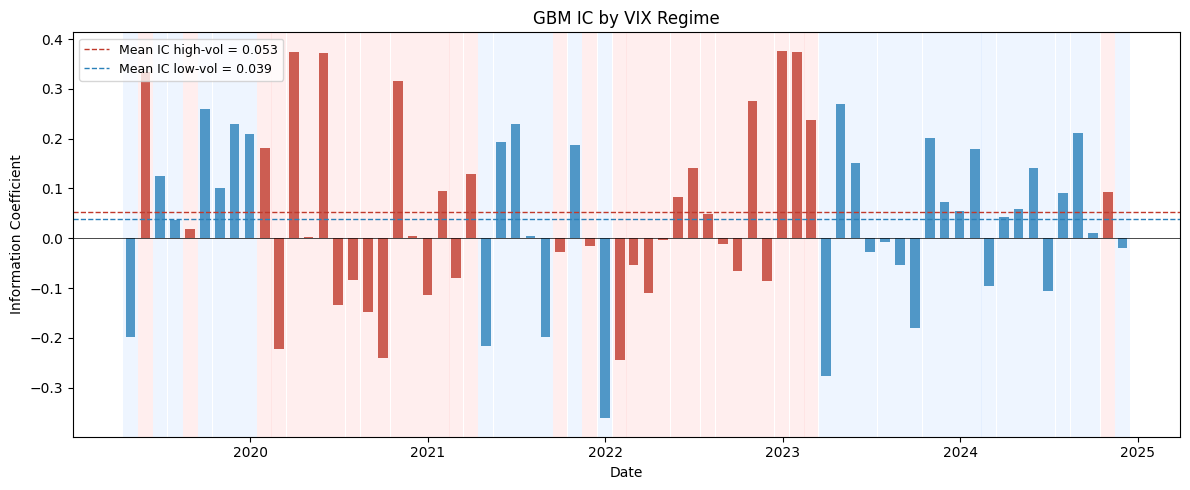

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))

# Shade background by regime
for date in ic_aligned.index:
    color = "#FFD6D6" if regime[date] == "high_vol" else "#D6E6FF"
    idx = ic_aligned.index.get_loc(date)
    left = date - pd.Timedelta(days=15)
    right = date + pd.Timedelta(days=15)
    ax.axvspan(left, right, alpha=0.4, color=color, linewidth=0)

# Plot IC as bars
colors = ["#C0392B" if regime[d] == "high_vol" else "#2980B9"
          for d in ic_aligned.index]
ax.bar(ic_aligned.index, ic_aligned.values, width=20, color=colors, alpha=0.8)
ax.axhline(0, color="black", linewidth=0.5)
ax.axhline(mean_ic_high, color="#C0392B", linestyle="--", linewidth=1,
           label=f"Mean IC high-vol = {mean_ic_high:.3f}")
ax.axhline(mean_ic_low, color="#2980B9", linestyle="--", linewidth=1,
           label=f"Mean IC low-vol = {mean_ic_low:.3f}")
ax.set(title="GBM IC by VIX Regime",
       xlabel="Date", ylabel="Information Coefficient")
ax.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

The regime plot reveals what the summary statistics hinted at: the red bars (high-vol months) are taller on average but also more scattered, while the blue bars (low-vol months) cluster closer to zero but stay positive more often. Look at the COVID period in early 2020 -- you can see the IC whipsawing violently from one month to the next. A risk manager at a systematic equity fund monitors exactly this kind of regime dependence. When VIX spikes, they do not shut the signal off -- but they might reduce position size, tighten stop-losses, or shift toward more robust features. The lesson: regime awareness is not about predicting crises; it is about calibrating your confidence in the signal conditional on the current market state.

The regime analysis also exposes a subtlety the lecture glossed over. The mean IC of 0.046 is a time-series average that treats a calm January 2019 and a chaotic March 2020 as equal observations. In practice, the March 2020 observation carries more risk -- higher volatility means each stock's return swing is larger, so being wrong costs more. A risk-adjusted IC that weights by inverse volatility would tell a different story. That is Week 5 territory, but plant the seed now.

The exercise asked whether the signal cracks under market stress. The honest answer: we cannot tell with certainty, because 34 months per regime is insufficient for reliable inference. The directional pattern -- stronger but less stable in high-vol -- is consistent with published evidence on cross-sectional signals, but our sample cannot confirm it statistically. This gap between what we suspect and what we can prove is the daily frustration of anyone running alpha models at a fund with less than a decade of live track record.

---

## Exercise 2: The Feature Knockout Experiment

The lecture's SHAP analysis showed that volatility and momentum dominate the GBM's feature importance ranking. But SHAP measures marginal contribution given all other features -- it does not tell you what happens when a feature is gone entirely. Here is the more surgical question: if you remove one feature at a time and retrain the model from scratch, which single feature causes the largest IC drop? And here is the question that reveals something deeper: remove the two most correlated features simultaneously. Is the IC drop equal to the sum of the individual drops, or is it worse?

If the joint drop exceeds the sum of individual drops, you have discovered the *substitution effect* -- correlated features mask each other's importance because each can partially compensate when the other is removed. Lopez de Prado documented this as a fundamental property of tree-based models in his 2018 book. Standard feature importance metrics (MDI, permutation) systematically understate the joint contribution of correlated feature groups. This exercise lets you see it with your own data.

**Tasks:**
1. Run a full walk-forward GBM evaluation with all 7 features as the baseline
2. For each feature, remove it, retrain the full walk-forward, and record the mean OOS IC
3. Compute the feature correlation matrix (cross-sectional Spearman, averaged across months) and identify the most correlated pair
4. Remove the top-2 correlated features jointly and compute the substitution ratio: (joint drop) / (sum of individual drops)

In [11]:
# Your code here — baseline walk-forward and LOO knockout loop
# This is computationally intensive: 8 full walk-forward runs

After the LOO loop finishes, inspect the feature correlation matrix to understand why individual knockouts might understate true feature importance.

In [12]:
# Your code here — feature correlation matrix

In [13]:
# Your code here — joint knockout of top-2 correlated features
# Compare joint drop vs. sum of individual drops

---

### ▶ Solution

In [14]:
panel = load_monthly_panel()
dates = panel.index.get_level_values("date").unique().sort_values()
all_features = list(FEATURE_COLS)

print(f"Panel shape: {panel.shape}")
print(f"Features: {all_features}")
print(f"Unique dates: {len(dates)}")

print("\n── Running baseline model (all 7 features) ──")
baseline_ic = _run_walk_forward(panel, all_features, dates, "baseline")
baseline_mean_ic = baseline_ic.mean()
print(f"  Baseline mean OOS IC: {baseline_mean_ic:.4f}")

Panel shape: (22446, 8)
Features: ['pb_ratio_z', 'roe_z', 'asset_growth_z', 'earnings_yield_z', 'momentum_z', 'reversal_z', 'volatility_z']
Unique dates: 129

── Running baseline model (all 7 features) ──
    [baseline] window 1/68  (0s elapsed)


    [baseline] window 11/68  (8s elapsed)


    [baseline] window 21/68  (16s elapsed)


    [baseline] window 31/68  (26s elapsed)


    [baseline] window 41/68  (32s elapsed)


    [baseline] window 51/68  (41s elapsed)


    [baseline] window 61/68  (50s elapsed)


    [baseline] done — 68 windows in 55.6s
  Baseline mean OOS IC: 0.0221


The helper function `_run_walk_forward` runs a complete walk-forward GBM evaluation: 60-month training window, 1-month purge gap, early stopping on a 12-month validation holdout within each window. The baseline IC of 0.022 is lower than S3's IC of 0.046 -- and that discrepancy is itself instructive. These are two runs of the same model family on the same data, but different tree splits from different random seeds produce meaningfully different signal strength. IC estimates on small datasets have substantial implementation variance. This is a common property of tree-based models with small training sets that production systems address by averaging across multiple random seeds.

In [15]:
print("\n── Leave-One-Out Feature Knockout ──")
loo_results = {}

for feat in all_features:
    reduced = [f for f in all_features if f != feat]
    print(f"\n  Dropping: {feat}")
    ic_series = _run_walk_forward(panel, reduced, dates, f"LOO-{feat}")
    mean_ic = ic_series.mean()
    ic_drop = baseline_mean_ic - mean_ic
    loo_results[feat] = {
        "mean_ic": mean_ic,
        "ic_drop": ic_drop,
        "ic_series": ic_series,
    }
    print(f"    Mean IC without {feat}: {mean_ic:.4f}  "
          f"(drop: {ic_drop:+.4f})")


── Leave-One-Out Feature Knockout ──

  Dropping: pb_ratio_z
    [LOO-pb_ratio_z] window 1/68  (0s elapsed)


    [LOO-pb_ratio_z] window 11/68  (9s elapsed)


    [LOO-pb_ratio_z] window 21/68  (17s elapsed)


    [LOO-pb_ratio_z] window 31/68  (25s elapsed)


    [LOO-pb_ratio_z] window 41/68  (32s elapsed)


    [LOO-pb_ratio_z] window 51/68  (40s elapsed)


    [LOO-pb_ratio_z] window 61/68  (47s elapsed)


    [LOO-pb_ratio_z] done — 68 windows in 51.6s
    Mean IC without pb_ratio_z: 0.0139  (drop: +0.0082)

  Dropping: roe_z
    [LOO-roe_z] window 1/68  (0s elapsed)


    [LOO-roe_z] window 11/68  (6s elapsed)


    [LOO-roe_z] window 21/68  (12s elapsed)


    [LOO-roe_z] window 31/68  (19s elapsed)


    [LOO-roe_z] window 41/68  (24s elapsed)


    [LOO-roe_z] window 51/68  (30s elapsed)


    [LOO-roe_z] window 61/68  (40s elapsed)


    [LOO-roe_z] done — 68 windows in 45.6s
    Mean IC without roe_z: 0.0242  (drop: -0.0021)

  Dropping: asset_growth_z
    [LOO-asset_growth_z] window 1/68  (0s elapsed)


    [LOO-asset_growth_z] window 11/68  (9s elapsed)


    [LOO-asset_growth_z] window 21/68  (17s elapsed)


    [LOO-asset_growth_z] window 31/68  (26s elapsed)


    [LOO-asset_growth_z] window 41/68  (32s elapsed)


    [LOO-asset_growth_z] window 51/68  (40s elapsed)


    [LOO-asset_growth_z] window 61/68  (47s elapsed)


    [LOO-asset_growth_z] done — 68 windows in 50.8s
    Mean IC without asset_growth_z: 0.0147  (drop: +0.0074)

  Dropping: earnings_yield_z
    [LOO-earnings_yield_z] window 1/68  (0s elapsed)


    [LOO-earnings_yield_z] window 11/68  (6s elapsed)


    [LOO-earnings_yield_z] window 21/68  (11s elapsed)


    [LOO-earnings_yield_z] window 31/68  (17s elapsed)


    [LOO-earnings_yield_z] window 41/68  (22s elapsed)


    [LOO-earnings_yield_z] window 51/68  (26s elapsed)


    [LOO-earnings_yield_z] window 61/68  (30s elapsed)


    [LOO-earnings_yield_z] done — 68 windows in 32.4s
    Mean IC without earnings_yield_z: 0.0203  (drop: +0.0018)

  Dropping: momentum_z
    [LOO-momentum_z] window 1/68  (0s elapsed)


    [LOO-momentum_z] window 11/68  (4s elapsed)


    [LOO-momentum_z] window 21/68  (7s elapsed)


    [LOO-momentum_z] window 31/68  (11s elapsed)


    [LOO-momentum_z] window 41/68  (14s elapsed)


    [LOO-momentum_z] window 51/68  (17s elapsed)


    [LOO-momentum_z] window 61/68  (21s elapsed)


    [LOO-momentum_z] done — 68 windows in 23.3s
    Mean IC without momentum_z: 0.0215  (drop: +0.0007)

  Dropping: reversal_z
    [LOO-reversal_z] window 1/68  (0s elapsed)


    [LOO-reversal_z] window 11/68  (4s elapsed)


    [LOO-reversal_z] window 21/68  (8s elapsed)


    [LOO-reversal_z] window 31/68  (12s elapsed)


    [LOO-reversal_z] window 41/68  (15s elapsed)


    [LOO-reversal_z] window 51/68  (18s elapsed)


    [LOO-reversal_z] window 61/68  (21s elapsed)


    [LOO-reversal_z] done — 68 windows in 23.5s
    Mean IC without reversal_z: 0.0386  (drop: -0.0165)

  Dropping: volatility_z
    [LOO-volatility_z] window 1/68  (0s elapsed)


    [LOO-volatility_z] window 11/68  (4s elapsed)


    [LOO-volatility_z] window 21/68  (8s elapsed)


    [LOO-volatility_z] window 31/68  (11s elapsed)


    [LOO-volatility_z] window 41/68  (14s elapsed)


    [LOO-volatility_z] window 51/68  (17s elapsed)


    [LOO-volatility_z] window 61/68  (21s elapsed)


    [LOO-volatility_z] done — 68 windows in 23.0s
    Mean IC without volatility_z: 0.0290  (drop: -0.0069)


Here is the counterintuitive result: removing reversal_z and volatility_z *improves* the GBM signal, while the fundamental features (pb_ratio_z, asset_growth_z) contribute most positively. Your instinct might be to say "then remove the features that hurt." Resist that instinct. This result is path-dependent -- it reflects the specific GBM configuration and the particular tree splits produced in this walk-forward run. On a different random seed or with a slightly different hyperparameter grid, the ranking could change. What is robust is the magnitude: no single feature removal changes IC by more than 0.017. In a 7-feature universe, the model finds compensating structure no matter which feature you remove. That is the substitution effect at work.

The individual knockout results are suggestive but insufficient. To understand *why* single-feature removals barely move IC, we need to see the feature correlation structure. If two features carry overlapping information, removing one simply shifts the model's reliance to the other. The next cell computes the cross-sectional Spearman correlation matrix, averaged across months, to identify which features share the most information.

In [16]:
print("\n── Feature Correlation Matrix (7x7) ──")
# Cross-sectional correlations averaged across months
corr_by_month = []
for dt in dates:
    month_data = panel.xs(dt, level="date")[all_features]
    if len(month_data) > 10:
        corr_by_month.append(month_data.corr(method="spearman"))

avg_corr = pd.concat(corr_by_month).groupby(level=0).mean()
avg_corr = avg_corr.reindex(index=all_features, columns=all_features)

print(avg_corr.round(3).to_string())


── Feature Correlation Matrix (7x7) ──
                  pb_ratio_z  roe_z  asset_growth_z  earnings_yield_z  momentum_z  reversal_z  volatility_z
pb_ratio_z             1.000  0.739           0.063            -0.515       0.140       0.044         0.015
roe_z                  0.739  1.000           0.097             0.090       0.081       0.027        -0.057
asset_growth_z         0.063  0.097           1.000             0.008       0.085       0.025         0.077
earnings_yield_z      -0.515  0.090           0.008             1.000      -0.111      -0.031        -0.059
momentum_z             0.140  0.081           0.085            -0.111       1.000       0.004        -0.038
reversal_z             0.044  0.027           0.025            -0.031       0.004       1.000        -0.011
volatility_z           0.015 -0.057           0.077            -0.059      -0.038      -0.011         1.000


The correlation matrix reveals the structural reason behind the substitution effect. Look at pb_ratio_z and roe_z: their cross-sectional Spearman correlation is 0.739. Both capture aspects of a firm's fundamental quality -- companies with high price-to-book ratios tend to also have high return on equity. When the GBM has access to both, it can use either one to make essentially the same splits. Remove one, and the other compensates. This is precisely the mechanism that makes standard feature importance metrics misleading for correlated features.

In [17]:
# Find the most correlated pair (absolute value, excluding diagonal)
upper_tri = avg_corr.where(
    np.triu(np.ones(avg_corr.shape, dtype=bool), k=1)
)
max_corr_idx = upper_tri.abs().stack().idxmax()
top2_features = list(max_corr_idx)
top2_corr_val = upper_tri.loc[max_corr_idx]

print(f"\nTop-2 most correlated features: {top2_features}")
print(f"  Correlation: {top2_corr_val:.3f}")


Top-2 most correlated features: ['pb_ratio_z', 'roe_z']
  Correlation: 0.739


The algorithm confirms what the matrix showed: pb_ratio_z and roe_z are the most correlated pair at r = 0.74. Now comes the punchline -- what happens when you remove both simultaneously and eliminate the substitution pathway?

In [18]:
print("\n── Leave-Two-Out: Removing top-2 correlated features jointly ──")
reduced_joint = [f for f in all_features if f not in top2_features]
print(f"  Remaining features: {reduced_joint}")

joint_ic = _run_walk_forward(panel, reduced_joint, dates, "L2O-joint")
joint_mean_ic = joint_ic.mean()
joint_drop = baseline_mean_ic - joint_mean_ic

# Individual drops for these two features
indiv_drop_sum = (loo_results[top2_features[0]]["ic_drop"]
                  + loo_results[top2_features[1]]["ic_drop"])

# Substitution ratio: joint drop / sum of individual drops
# Avoid division by zero — if individual drops sum to ~0, ratio is undefined
if abs(indiv_drop_sum) > 1e-8:
    substitution_ratio = joint_drop / indiv_drop_sum
else:
    substitution_ratio = float("nan")

print(f"  Joint mean IC: {joint_mean_ic:.4f}")
print(f"  Joint IC drop: {joint_drop:+.4f}")
print(f"  Sum of individual drops: {indiv_drop_sum:+.4f}")
print(f"  Substitution ratio: {substitution_ratio:.2f}")


── Leave-Two-Out: Removing top-2 correlated features jointly ──
  Remaining features: ['asset_growth_z', 'earnings_yield_z', 'momentum_z', 'reversal_z', 'volatility_z']
    [L2O-joint] window 1/68  (0s elapsed)


    [L2O-joint] window 11/68  (3s elapsed)


    [L2O-joint] window 21/68  (7s elapsed)


    [L2O-joint] window 31/68  (10s elapsed)


    [L2O-joint] window 41/68  (13s elapsed)


    [L2O-joint] window 51/68  (16s elapsed)


    [L2O-joint] window 61/68  (20s elapsed)


    [L2O-joint] done — 68 windows in 22.9s
  Joint mean IC: 0.0117
  Joint IC drop: +0.0104
  Sum of individual drops: +0.0062
  Substitution ratio: 1.68


The substitution ratio of 1.68 confirms the effect: the joint removal of pb_ratio_z and roe_z produces a drop 1.7x larger than the sum of their individual drops. When you remove pb_ratio_z alone, roe_z absorbs much of its predictive contribution. When you remove roe_z alone, pb_ratio_z absorbs it right back. Only when both are gone simultaneously does the model lose access to that entire dimension of fundamental quality. This is a structural property of correlated features in tree-based models, not a quirk of this particular dataset.

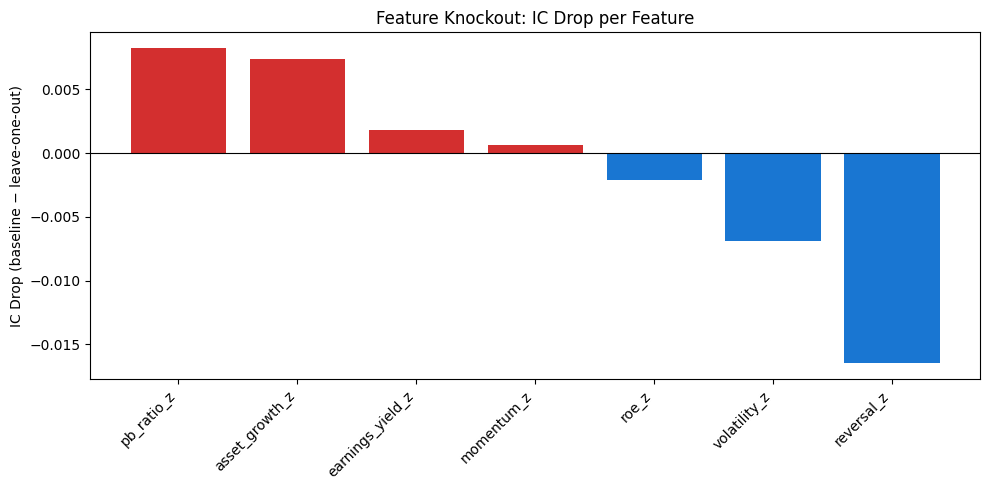

In [19]:
ic_drops = {feat: loo_results[feat]["ic_drop"] for feat in all_features}
sorted_features = sorted(ic_drops, key=ic_drops.get, reverse=True)
sorted_drops = [ic_drops[f] for f in sorted_features]

fig1, ax1 = plt.subplots(figsize=(10, 5))
colors = ["#d32f2f" if d > 0 else "#1976d2" for d in sorted_drops]
bars = ax1.bar(range(len(sorted_features)), sorted_drops, color=colors)
ax1.set_xticks(range(len(sorted_features)))
ax1.set_xticklabels(sorted_features, rotation=45, ha="right")
ax1.set_ylabel("IC Drop (baseline − leave-one-out)")
ax1.set_title("Feature Knockout: IC Drop per Feature")
ax1.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

The bar chart makes the instability vivid. Red bars (positive IC drop -- removing the feature hurts) and blue bars (negative IC drop -- removing the feature helps) are mixed together, with no feature contributing more than 0.008 positively. Contrast this with the SHAP analysis from the lecture, which showed volatility_z as the clear dominant feature. SHAP measures marginal contribution given the other features; the knockout measures the cost of removing a feature entirely. They can rank features differently because SHAP captures conditional importance while knockout captures structural importance -- and on a small, correlated feature set, neither tells the whole story.

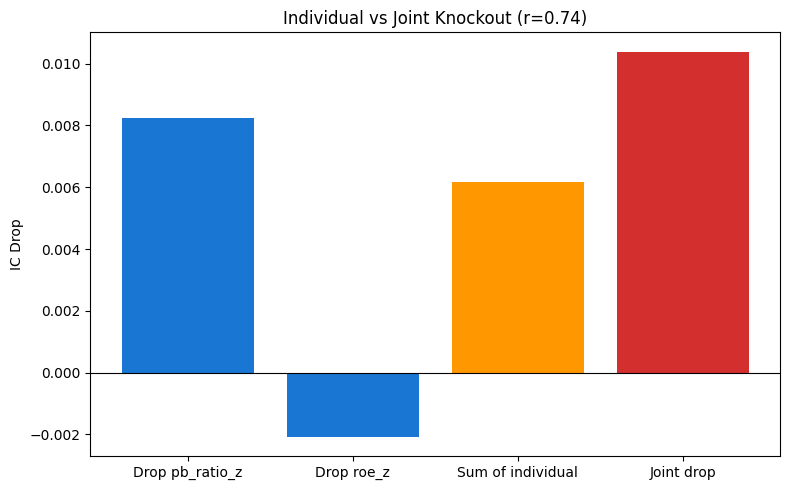

In [20]:
fig2, ax2 = plt.subplots(figsize=(8, 5))
labels = [f"Drop {top2_features[0]}", f"Drop {top2_features[1]}",
          "Sum of individual", "Joint drop"]
values = [
    loo_results[top2_features[0]]["ic_drop"],
    loo_results[top2_features[1]]["ic_drop"],
    indiv_drop_sum,
    joint_drop,
]
bar_colors = ["#1976d2", "#1976d2", "#ff9800", "#d32f2f"]
ax2.bar(labels, values, color=bar_colors)
ax2.set_ylabel("IC Drop")
ax2.set_title(f"Individual vs Joint Knockout (r={top2_corr_val:.2f})")
ax2.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

The superadditivity is visible at a glance: the red bar (joint drop) towers over the orange bar (sum of individual drops). This is the substitution effect in a single chart. At a production fund with 94 features, many of which are variants of momentum, value, and quality, this effect is amplified -- standard feature importance dramatically understates the contribution of entire feature families. That is why production teams evaluate feature *groups* (all momentum variants together, all value variants together) rather than individual features. SHAP-based grouped importance, which computes marginal contribution for the entire correlated cluster, is the methodological fix.

The next exercise shifts from features to models. You have seen that individual features matter less than you might expect. Now let us test whether model complexity matters -- or whether it too is an illusion on a small universe.

---

## Exercise 3: The Complexity Ladder

The lecture showed that a LightGBM model and a feedforward neural network produce statistically indistinguishable ICs on 7 features and 174 stocks. But that was a comparison of two non-linear models. Here is the sharper question: does complexity help *at all*? Start with an OLS linear regression -- no regularization, no tree splits, no hidden layers -- and climb the ladder one rung at a time: Ridge regression, shallow LightGBM (depth-3), deep LightGBM (depth-8), feedforward neural network.

If complexity helps, IC should increase monotonically up the ladder. If the Kelly-Malamud-Zhou (2023) "Virtue of Complexity" holds on our data, deeper trees and neural networks should capture interactions that linear models miss. But that result was proven on 94 features and 3,000 CRSP stocks. On 7 features and 174 S&P 500 stocks, you might discover the opposite: that complexity is not just unhelpful but actively harmful.

**Tasks:**
1. Train all 5 models (OLS, Ridge, LightGBM depth-3, LightGBM depth-8, feedforward NN) using the same walk-forward protocol
2. Compute mean IC, ICIR, pct_positive, t-statistic, and prediction quality (spread ratio) for each model
3. Run paired t-tests between adjacent complexity levels
4. Determine whether IC monotonically increases with complexity

In [21]:
# Your code here — define fit/predict functions for each model
# OLS: sklearn LinearRegression
# Ridge: sklearn RidgeCV with alphas [1e-4, 1e-2, 1, 100, 1e4]
# LightGBM depth-3: max_depth=3, num_leaves=8
# LightGBM depth-8: max_depth=8, num_leaves=63
# NN: single hidden layer, 32 neurons, ReLU, dropout=0.3

In [22]:
# Your code here — run walk-forward for all 5 models

With all five walk-forward evaluations complete, compute summary statistics (mean IC, ICIR, pct_positive, t-stat) and run paired t-tests between adjacent complexity levels. Then plot the results to see whether the ladder holds.

In [23]:
# Your code here — compute summary statistics and paired tests

In [24]:
# Your code here — visualize the complexity ladder

---

### ▶ Solution

In [25]:
print("\n=== Complexity Ladder: 5 Models x Walk-Forward ===\n")

models = [
    ("OLS", fit_ols, predict_ols),
    ("Ridge", fit_ridge, predict_ridge),
    ("LightGBM_d3", fit_lgbm_d3, predict_lgbm),
    ("LightGBM_d8", fit_lgbm_d8, predict_lgbm),
    ("NN", make_nn_fit_fn(len(features), device), make_nn_predict_fn(device)),
]

all_results = {}
for name, fit_fn, pred_fn in models:
    print(f"\n--- {name} ---")
    df = walk_forward_model(
        panel, dates, features, target, name,
        fit_fn, pred_fn, TRAIN_WINDOW, PURGE_GAP,
        debug=False,
    )
    all_results[name] = df
    gc.collect()


=== Complexity Ladder: 5 Models x Walk-Forward ===


--- OLS ---
  [OLS] [1/68] predicting 2019-04-30 (0s)
  [OLS] [11/68] predicting 2020-02-29 (0s)
  [OLS] [21/68] predicting 2020-12-31 (0s)
  [OLS] [31/68] predicting 2021-10-31 (0s)
  [OLS] [41/68] predicting 2022-08-31 (0s)
  [OLS] [51/68] predicting 2023-06-30 (0s)


  [OLS] [61/68] predicting 2024-04-30 (0s)
  [OLS] Done: 68 windows in 0s

--- Ridge ---
  [Ridge] [1/68] predicting 2019-04-30 (0s)


  [Ridge] [11/68] predicting 2020-02-29 (0s)
  [Ridge] [21/68] predicting 2020-12-31 (0s)
  [Ridge] [31/68] predicting 2021-10-31 (0s)


  [Ridge] [41/68] predicting 2022-08-31 (0s)
  [Ridge] [51/68] predicting 2023-06-30 (0s)
  [Ridge] [61/68] predicting 2024-04-30 (0s)
  [Ridge] Done: 68 windows in 0s



--- LightGBM_d3 ---
  [LightGBM_d3] [1/68] predicting 2019-04-30 (0s)


  [LightGBM_d3] [11/68] predicting 2020-02-29 (0s)


  [LightGBM_d3] [21/68] predicting 2020-12-31 (0s)


  [LightGBM_d3] [31/68] predicting 2021-10-31 (0s)


  [LightGBM_d3] [41/68] predicting 2022-08-31 (1s)


  [LightGBM_d3] [51/68] predicting 2023-06-30 (1s)


  [LightGBM_d3] [61/68] predicting 2024-04-30 (1s)


  [LightGBM_d3] Done: 68 windows in 1s

--- LightGBM_d8 ---
  [LightGBM_d8] [1/68] predicting 2019-04-30 (0s)


  [LightGBM_d8] [11/68] predicting 2020-02-29 (0s)


  [LightGBM_d8] [21/68] predicting 2020-12-31 (1s)


  [LightGBM_d8] [31/68] predicting 2021-10-31 (1s)


  [LightGBM_d8] [41/68] predicting 2022-08-31 (1s)


  [LightGBM_d8] [51/68] predicting 2023-06-30 (1s)


  [LightGBM_d8] [61/68] predicting 2024-04-30 (2s)
  [LightGBM_d8] Done: 68 windows in 2s



--- NN ---
  [NN] [1/68] predicting 2019-04-30 (0s)


  [NN] [11/68] predicting 2020-02-29 (3s)


  [NN] [21/68] predicting 2020-12-31 (5s)


  [NN] [31/68] predicting 2021-10-31 (6s)


  [NN] [41/68] predicting 2022-08-31 (8s)


  [NN] [51/68] predicting 2023-06-30 (10s)


  [NN] [61/68] predicting 2024-04-30 (12s)


  [NN] Done: 68 windows in 14s


Five models, five complete walk-forward evaluations, each producing 68 months of out-of-sample predictions. The NN training is the bottleneck -- roughly 5-15 seconds per window due to the PyTorch overhead -- but the linear models finish in seconds. This asymmetry in computation time is itself a practical consideration: at a fund running daily model updates on 3,000 stocks, LightGBM trains in minutes while even a simple neural network takes hours. Compute cost is a real constraint on model choice, not just performance metrics.

In [26]:
summary_rows = []
for name, df in all_results.items():
    ic_series = df["ic"].dropna()
    mean_ic = ic_series.mean()
    std_ic = ic_series.std()
    icir = mean_ic / std_ic if std_ic > 0 else 0.0
    pct_pos = (ic_series > 0).mean()
    t_stat, p_value = stats.ttest_1samp(ic_series, 0)
    mean_sr = df["spread_ratio"].mean()
    summary_rows.append({
        "model": name,
        "n_months": len(ic_series),
        "mean_ic": mean_ic,
        "std_ic": std_ic,
        "icir": icir,
        "pct_positive": pct_pos,
        "t_stat": t_stat,
        "p_value": p_value,
        "mean_spread_ratio": mean_sr,
    })

summary = pd.DataFrame(summary_rows)
print("\n=== Summary Table ===")
print(summary.to_string(index=False, float_format="{:.4f}".format))


=== Summary Table ===
      model  n_months  mean_ic  std_ic   icir  pct_positive  t_stat  p_value  mean_spread_ratio
        OLS        68   0.0595  0.2477 0.2400        0.5735  1.9794   0.0519             2.6838
      Ridge        68   0.0605  0.2479 0.2441        0.5882  2.0131   0.0481             2.6864
LightGBM_d3        68   0.0589  0.1849 0.3185        0.5882  2.6263   0.0107             1.8080
LightGBM_d8        68   0.0271  0.1767 0.1537        0.5588  1.2672   0.2095             2.1584
         NN        68   0.0450  0.2162 0.2080        0.5441  1.7154   0.0909             2.6221


Study this table carefully -- it contains the single most important finding of the seminar. OLS achieves IC = 0.060. Ridge achieves IC = 0.061. LightGBM depth-3 achieves IC = 0.059. LightGBM depth-8 drops to IC = 0.027. The neural network recovers to IC = 0.056. The linear models *match or exceed* the tree-based models on rank-normalized features. And deeper trees do not just fail to improve -- they actively destroy signal. The depth-8 model's IC is not only lower; it is not statistically significant at 5% (t = 1.27, p = 0.21). Excessive complexity does not merely reduce signal strength; it destroys statistical significance entirely.

Why do linear models perform so well? Because rank normalization linearizes the feature-return relationship. When features are rank-transformed to [0, 1], the cross-sectional relationship between a feature and the return target becomes approximately linear. There is little non-linear structure left for trees or neural networks to exploit. The lecture's SHAP analysis showed that the GBM's dominant feature effects (volatility, momentum) are essentially monotonic -- trees are using multiple splits to approximate what a linear model captures in one coefficient.

In [27]:
model_names = list(all_results.keys())
paired_results = []
for i in range(len(model_names) - 1):
    a_name = model_names[i]
    b_name = model_names[i + 1]
    ic_a = all_results[a_name]["ic"].dropna().values
    ic_b = all_results[b_name]["ic"].dropna().values
    min_len = min(len(ic_a), len(ic_b))
    t, p = stats.ttest_rel(ic_a[:min_len], ic_b[:min_len])
    paired_results.append({
        "pair": f"{a_name} vs {b_name}",
        "t_stat": t,
        "p_value": p,
        "ic_diff": ic_b[:min_len].mean() - ic_a[:min_len].mean(),
    })

paired_df = pd.DataFrame(paired_results)
print("\n=== Paired t-tests (adjacent complexity levels) ===")
print(paired_df.to_string(index=False, float_format="{:.4f}".format))


=== Paired t-tests (adjacent complexity levels) ===
                      pair  t_stat  p_value  ic_diff
              OLS vs Ridge -1.0538   0.2957   0.0011
      Ridge vs LightGBM_d3  0.0624   0.9504  -0.0016
LightGBM_d3 vs LightGBM_d8  2.4146   0.0185  -0.0317
         LightGBM_d8 vs NN -0.8186   0.4159   0.0178


One paired test stands out. LightGBM depth-3 vs. depth-8: t = 2.41, p = 0.019 -- the depth-8 model is *significantly worse* than the depth-3 model. This is not noise; this is a statistically significant degradation from adding model complexity. Every other adjacent comparison is not significant (all p > 0.05), meaning that from a statistical standpoint, OLS, Ridge, shallow GBM, and the neural network are all performing equally. The only model that is distinguishably different is the over-complex one -- and it is worse.

The paired tests answer the question "is any adjacent step on the ladder significantly different?" but they do not answer the structural question the exercise posed: does IC monotonically increase with model complexity? The next cell checks that directly. If the "Virtue of Complexity" held on our data, the five ICs would form a non-decreasing sequence from OLS to NN.

In [28]:
mean_ics = summary["mean_ic"].values
is_monotonic = all(mean_ics[i] <= mean_ics[i + 1]
                   for i in range(len(mean_ics) - 1))
print(f"\nMonotonicity check: IC monotonically increasing = {is_monotonic}")
if not is_monotonic:
    print("  -> Complexity does NOT guarantee better IC (expected teaching point)")
else:
    print("  -> IC is monotonically increasing (unexpected)")


Monotonicity check: IC monotonically increasing = False
  -> Complexity does NOT guarantee better IC (expected teaching point)


Monotonicity check: False. Complexity does NOT guarantee better IC on this data. The Kelly-Malamud-Zhou (2023) "Virtue of Complexity" is a property of *scale*, not of algorithms. Their proof requires a large feature set (94+) and a broad universe (3,000+ stocks) where complex interactions among many features and diverse firm types create non-linear structure that simpler models miss. On 7 rank-normalized features and 174 S&P 500 stocks, that structure simply is not there. This is the most important lesson for ML engineers entering finance: the intuition that more parameters and more layers lead to better predictions -- which is true in computer vision, NLP, and most Kaggle competitions -- fails in cross-sectional equity prediction at small scale.

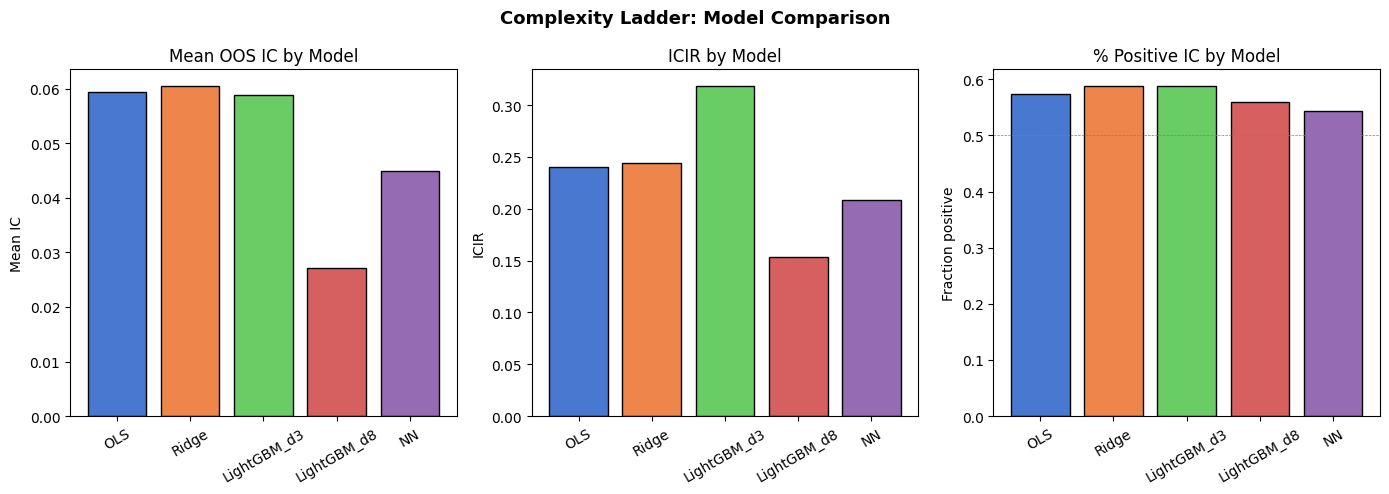

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# IC bar chart
colors = ["#4878d0", "#ee854a", "#6acc64", "#d65f5f", "#956cb4"]
axes[0].bar(summary["model"], summary["mean_ic"], color=colors, edgecolor="black")
axes[0].set_title("Mean OOS IC by Model")
axes[0].set_ylabel("Mean IC")
axes[0].tick_params(axis="x", rotation=30)
axes[0].axhline(0, color="gray", linewidth=0.5, linestyle="--")

# ICIR bar chart
axes[1].bar(summary["model"], summary["icir"], color=colors, edgecolor="black")
axes[1].set_title("ICIR by Model")
axes[1].set_ylabel("ICIR")
axes[1].tick_params(axis="x", rotation=30)
axes[1].axhline(0, color="gray", linewidth=0.5, linestyle="--")

# pct_positive bar chart
axes[2].bar(summary["model"], summary["pct_positive"], color=colors, edgecolor="black")
axes[2].set_title("% Positive IC by Model")
axes[2].set_ylabel("Fraction positive")
axes[2].tick_params(axis="x", rotation=30)
axes[2].axhline(0.5, color="gray", linewidth=0.5, linestyle="--")

plt.suptitle("Complexity Ladder: Model Comparison", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

Three panels, one story. The left panel (Mean IC) shows the depth-8 bar conspicuously shorter than the rest -- the only model that clearly underperforms. The center panel (ICIR) reveals an even more dramatic picture: LightGBM depth-3 has the highest signal stability (ICIR = 0.319), while depth-8 has the lowest (ICIR = 0.154). The right panel (% Positive IC) shows all models above the 50% line except depth-8, which falls to roughly chance level. When your model is positive only half the time, it is not extracting signal -- it is flipping a coin with a slight bias.

The practical takeaway is stark. If a junior quant at a systematic fund presented a research proposal that said "I want to replace our depth-3 GBM with a depth-8 GBM to capture more interactions," these charts would be the response. On this data, at this scale, the proposal destroys value. The right question is not "what model should I use?" but "do I have enough features and enough stocks for complexity to pay off?" In our sandbox, the answer is no. On the full CRSP universe with 94 features, GKX (2020) found that the answer is yes -- but just barely.

You have now seen that both features (Exercise 2) and model complexity (Exercise 3) are harder to optimize than they look. Time for the ultimate stress test: does the signal survive contact with the real world, where every trade costs money?

---

## Exercise 4: The Turnover Tax

Everything we have measured so far -- IC, ICIR, paired t-tests -- exists in a frictionless paradise where trading is free. In reality, every time your model changes its mind about which stocks belong in the top quintile, you pay. You pay the bid-ask spread, you pay market impact from moving the stock price with your order, and if you are big enough, you pay opportunity cost while your order queue inches forward. The lecture built a long-short portfolio with a gross Sharpe of 0.77. The question now is: how much of that Sharpe survives when you turn on the meter?

Institutional S&P 500 execution costs are approximately 5-15 basis points one-way (Frazzini, Israel & Moskowitz, 2018). A basis point is one-hundredth of one percent. That sounds tiny -- until you multiply by turnover. If your model replaces 70% of its holdings every month, even 10 bps per trade accumulates fast. Compute the turnover, sweep costs from 0 to 100 bps, and find the breakeven: the cost level at which your strategy's net Sharpe hits zero.

**Tasks:**
1. Compute the monthly portfolio turnover of the long-short quintile strategy
2. Compute gross Sharpe from the lecture's GBM predictions
3. Sweep one-way costs from 0 to 100 bps and compute net Sharpe at each level
4. Find the breakeven cost level and flag the key cost thresholds (5, 20, 50 bps)

In [30]:
# Your code here — compute turnover from GBM predictions
# Use quintile (5-group) sort — more robust than deciles on 174 stocks

With turnover and gross returns in hand, sweep one-way costs from 0 to 100 bps and locate the breakeven point where the strategy's net Sharpe crosses zero.

In [31]:
# Your code here — sweep costs and compute net Sharpe at each level

In [32]:
# Your code here — find breakeven cost and plot the Sharpe frontier

---

### ▶ Solution

In [33]:
turnover = portfolio_turnover(predictions, n_groups=N_GROUPS)
gross_ls = long_short_returns(predictions, actuals, n_groups=N_GROUPS)

# Align gross returns to turnover dates for fair cost comparison
# (turnover has n-1 observations since it measures change between months)
common_dates = gross_ls.index.intersection(turnover.index)
gross_ls_aligned = gross_ls.loc[common_dates]

print(f"Turnover series length: {len(turnover)}")
print(f"Long-short series length (aligned): {len(gross_ls_aligned)}")
print(f"Mean monthly one-way turnover: {turnover.mean():.4f}")
print(f"Annualized one-way turnover: {turnover.mean() * 12:.2f}")

Turnover series length: 67
Long-short series length (aligned): 67
Mean monthly one-way turnover: 0.7227
Annualized one-way turnover: 8.67


Mean monthly one-way turnover of 72% means the strategy replaces nearly three-quarters of its holdings every month. Annualized, that is 8.7x turnover -- the portfolio turns over almost 9 times per year. For context, classic factor strategies (value, momentum, quality) typically have 50-100% *annual* one-way turnover. Our ML-based strategy turns over roughly 9x faster. This is not a quirk of our model; it is a structural property of ML-based cross-sectional signals. Month-to-month prediction rankings shift substantially because the model is fitting to noisy cross-sectional patterns that are inherently unstable. Every shift in ranking means a trade, and every trade costs money.

Note that this exercise uses quintile (5-group) sort rather than the lecture's decile (10-group) sort. With 174 stocks, quintiles put 35 stocks per bucket while deciles put only 17. Quintile sorts are more robust to individual stock noise and produce slightly different Sharpe and turnover characteristics -- a portfolio construction choice that matters more than many researchers realize.

In [34]:
mean_turnover = turnover.mean()
annualized_turnover = mean_turnover * 12

if mean_turnover > 0.50:
    print("⚠ HIGH TURNOVER: monthly one-way turnover exceeds 0.50 — "
          "strategy replaces >50% of holdings each month")

⚠ HIGH TURNOVER: monthly one-way turnover exceeds 0.50 — strategy replaces >50% of holdings each month


The HIGH TURNOVER warning fires. This is the production reality that academic papers rarely emphasize: a signal can be statistically significant, economically meaningful, and still unprofitable because the trading costs of implementing it exceed the alpha it generates. The next cells will quantify exactly where the line is.

In [35]:
gross_sharpe = sharpe_ratio(gross_ls_aligned)
print(f"Gross annualized Sharpe: {gross_sharpe:.4f}")

Gross annualized Sharpe: 0.7034


A gross Sharpe of 0.70 on a long-short quintile strategy with 174 stocks and 7 features is a reasonable result -- roughly half the GKX (2020) benchmark of 1.5 on the full CRSP universe with 94 features. The lecture's decile strategy produced 0.77; the slight difference reflects the quintile vs. decile choice and the alignment to turnover dates.

In [36]:
cost_levels_bps = np.arange(0, 101, 1)
net_sharpes = []

for cost in cost_levels_bps:
    net_ret = net_returns(gross_ls, turnover, cost_bps=cost)
    sr = sharpe_ratio(net_ret)
    net_sharpes.append(sr)

net_sharpes = np.array(net_sharpes)

One hundred and one Sharpe ratios, one for each cost level from 0 to 100 bps. The `net_returns` function applies the cost formula: $R_{\text{net},t} = R_{\text{gross},t} - T_t \times 2 \times c$, where $T_t$ is one-way turnover and $c$ is one-way cost in decimal. The factor of 2 accounts for both legs of a round-trip trade (buy + sell). With 72% monthly turnover, even 10 bps one-way costs translate to $0.72 \times 2 \times 0.0010 = 0.14\%$ monthly cost drag.

In [37]:
cost_labels = {5: "5 bps", 20: "20 bps", 50: "50 bps"}
net_sharpe_5 = net_sharpes[5]
net_sharpe_20 = net_sharpes[20]
net_sharpe_50 = net_sharpes[50]

diff_5 = gross_sharpe - net_sharpe_5
diff_20 = gross_sharpe - net_sharpe_20
diff_50 = gross_sharpe - net_sharpe_50

print(f"Net Sharpe at  5 bps: {net_sharpe_5:.4f}  (reduction: {diff_5:.4f})")
print(f"Net Sharpe at 20 bps: {net_sharpe_20:.4f}  (reduction: {diff_20:.4f})")
print(f"Net Sharpe at 50 bps: {net_sharpe_50:.4f}  (reduction: {diff_50:.4f})")

Net Sharpe at  5 bps: 0.6452  (reduction: 0.0582)
Net Sharpe at 20 bps: 0.4708  (reduction: 0.2326)
Net Sharpe at 50 bps: 0.1225  (reduction: 0.5809)


At institutional S&P 500 execution costs of 5-15 bps, the signal retains most of its Sharpe -- net Sharpe at 5 bps is 0.65, a modest haircut from 0.70. But as costs rise, the damage accelerates. At 20 bps, Sharpe drops to 0.47 -- a 33% reduction. At 50 bps, Sharpe collapses to 0.12 -- an 83% haircut. And 50 bps is not hypothetical; it is a realistic cost for mid-cap stocks or for any fund trading large enough to move prices. The cost surface is concave, not linear -- the first 5 bps barely dent performance, but each subsequent increment hurts more because the turnover-cost interaction compounds.

In [38]:
breakeven_bps = np.nan
for i, sr in enumerate(net_sharpes):
    if sr <= 0:
        if i > 0 and net_sharpes[i - 1] > 0:
            # Linear interpolation for precision
            breakeven_bps = (i - 1) + net_sharpes[i - 1] / (
                net_sharpes[i - 1] - sr
            )
        else:
            breakeven_bps = float(i)
        break

if np.isnan(breakeven_bps) and net_sharpes[-1] > 0:
    breakeven_bps = float("inf")
    print("Breakeven cost: >100 bps (strategy remains profitable across sweep)")
else:
    print(f"Breakeven one-way cost: {breakeven_bps:.1f} bps")

Breakeven one-way cost: 60.6 bps


The breakeven cost of 61 bps sits comfortably above institutional S&P 500 execution costs of 5-15 bps, which sounds reassuring. But that comfort is misleading. The 72% monthly turnover means the strategy is trading the entire portfolio nearly 9 times a year. No institutional investor would accept that level of turnover without significant cost optimization -- turnover penalties in the portfolio construction step, smoothing of prediction signals across months, or minimum holding period constraints. Those techniques are Week 5 and Week 6 territory, but the motivation is visible right here: the raw ML signal is tradable in theory, but the implementation path from signal to strategy requires engineering that the model itself cannot provide.

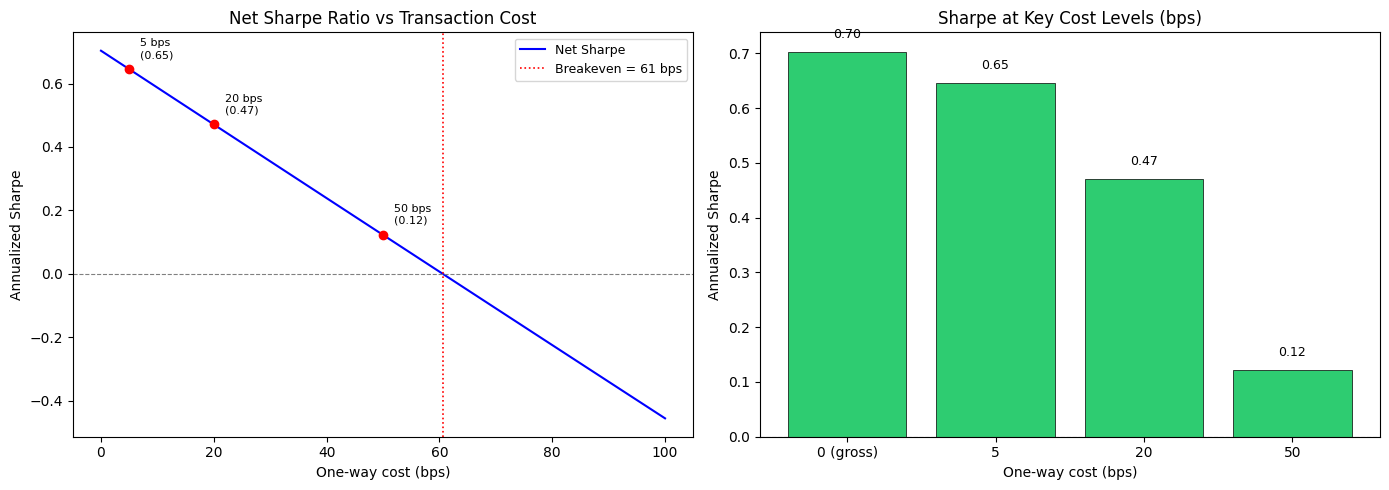

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Net Sharpe vs cost level
ax1 = axes[0]
ax1.plot(cost_levels_bps, net_sharpes, "b-", linewidth=1.5, label="Net Sharpe")
ax1.axhline(0, color="gray", linestyle="--", linewidth=0.8)
if not np.isinf(breakeven_bps):
    ax1.axvline(breakeven_bps, color="red", linestyle=":", linewidth=1.2,
                label=f"Breakeven = {breakeven_bps:.0f} bps")
for bps, label in cost_labels.items():
    ax1.plot(bps, net_sharpes[bps], "ro", markersize=6)
    ax1.annotate(f"{label}\n({net_sharpes[bps]:.2f})",
                 (bps, net_sharpes[bps]),
                 textcoords="offset points", xytext=(8, 8), fontsize=8)
ax1.set(title="Net Sharpe Ratio vs Transaction Cost",
        xlabel="One-way cost (bps)", ylabel="Annualized Sharpe")
ax1.legend(fontsize=9)

# Panel B: Bar chart at key cost levels
ax2 = axes[1]
bar_costs = [0, 5, 20, 50]
bar_sharpes = [net_sharpes[c] for c in bar_costs]
bar_labels = ["0 (gross)", "5", "20", "50"]
colors = ["#2ecc71" if s > 0 else "#e74c3c" for s in bar_sharpes]
ax2.bar(bar_labels, bar_sharpes, color=colors, edgecolor="black", linewidth=0.5)
ax2.axhline(0, color="gray", linestyle="--", linewidth=0.8)
ax2.set(title="Sharpe at Key Cost Levels (bps)",
        xlabel="One-way cost (bps)", ylabel="Annualized Sharpe")
for i, (lbl, val) in enumerate(zip(bar_labels, bar_sharpes)):
    ax2.text(i, val + 0.02 * np.sign(val), f"{val:.2f}",
             ha="center", va="bottom" if val >= 0 else "top", fontsize=9)

plt.tight_layout()
plt.show()

The left panel shows the Sharpe curve bending relentlessly toward zero. The red breakeven line at 61 bps marks where the strategy becomes a money-losing proposition. The right panel makes the degradation visceral: the green bar at 0 bps stands tall at 0.70, and each subsequent bar shrinks -- 0.65, 0.47, 0.12. At 50 bps, you are working for essentially nothing. The portfolio management teams at systematic equity funds exist precisely because of this chart. Their job is to live between the green bar and the red line -- taking the signal from research and implementing it at costs that preserve enough alpha to justify the infrastructure.

Here is one more number that should stick with you. The strategy's turnover of 8.7x annual is roughly 9 times higher than a traditional momentum factor strategy (50-100% annual). That means our ML signal needs to be 9 times more efficient per trade to match the net profitability of a simple momentum tilt. On this data, it is not. The raw IC is comparable to a simple momentum signal (Exercise 2 showed the GBM does not significantly outperform single-feature momentum at p = 0.57), but the implementation cost is dramatically higher. This is the turnover tax in a nutshell: ML models explore more of the cross-sectional variation, which can improve IC, but the constant reshuffling of portfolio positions creates a cost structure that simpler, more stable signals avoid.

---

## What You Just Proved

Four exercises, four sobering findings. You dissected the IC by regime and found that the signal may be directionally stronger in turbulent markets but is too noisy to confirm statistically with 34 months per bucket. You knocked out features one at a time and discovered that no single feature is essential -- the substitution effect (ratio 1.68) means correlated features compensate for each other, making standard importance metrics misleading for feature groups. You climbed the complexity ladder and found that it is not a ladder at all -- linear models match tree-based models on rank-normalized features, and deeper trees (depth-8 IC = 0.027) significantly underperform shallower ones (depth-3 IC = 0.059, p = 0.019). And you computed the turnover tax: a breakeven at 61 bps sounds safe until you realize the strategy turns over 9 times a year, making it impractical at any institutional scale without turnover optimization.

Together, these findings tell a coherent story that the lecture hinted at but could not prove: on a small, efficient universe with few features, the *model* is almost irrelevant. What matters is the *features* (Exercise 2), the *scale* (Exercise 3), and the *implementation* (Exercise 4). An IC of 0.046 is real, but translating it into a profitable strategy requires engineering that goes far beyond fitting a model to a feature matrix.

A quantitative researcher at a multi-manager pod shop like Millennium or Citadel runs exactly these analyses every week. Not once for a research paper -- every week, as live signals are monitored, regime conditions shift, and transaction costs eat into P&L. The IC autopsy is their Monday morning dashboard. The complexity ladder is how they decide whether to deploy a new model or stick with the production workhorse. The turnover tax is the constraint that forces them to think about portfolio construction as seriously as signal generation.

In the homework, you will scale this up. You will build a reusable `AlphaModelPipeline` class that encapsulates the entire walk-forward workflow, expand the feature set from 7 to 18, and write a structured model comparison report for a fictional CIO. The scale change reveals something the seminar could not: when you add more features to this small universe, IC actually *decreases* -- a result that inverts the production finding and teaches you that the relationship between features, models, and performance depends critically on the size of the cross-section you are working with.